In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    summary = run.summary._json_dict
    config = run.config
    name = run.name

    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("best_AUROC"),
        "AUROC_HQ": summary.get("best_AUROC_HQ"),
        "Accuracy": summary.get("best_Accuracy"),
        "Accuracy_HQ": summary.get("best_Accuracy_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

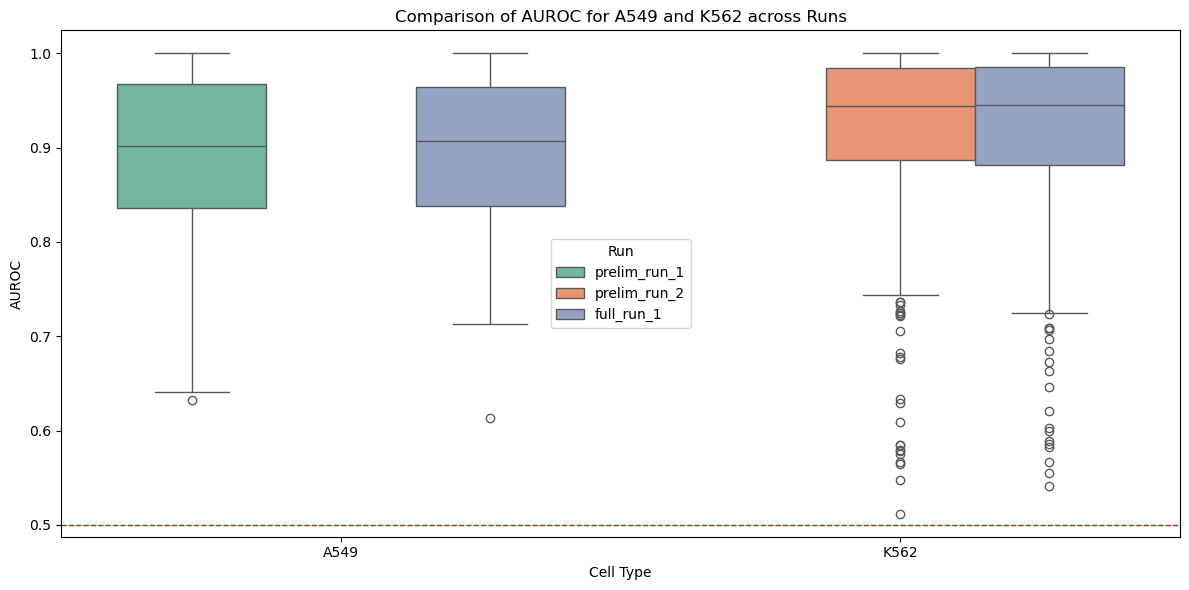

In [3]:
# Filter for cell types A549 and K562 and runs from prelim_run_1, prelim_run_2, and full_run_1
cell_types = ["A549", "K562"]
filtered_results = results_df[
    (results_df["celltype"].isin(cell_types)) &
    (results_df["group_name"].isin(["prelim_run_1", "prelim_run_2", "full_run_1"]))
]

# Create a boxplot to compare AUROC across runs for each cell type
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_results, x="celltype", y="AUROC", hue="group_name", palette="Set2")
plt.title("Comparison of AUROC for A549 and K562 across Runs")
plt.xlabel("Cell Type")
plt.ylabel("AUROC")
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1)
plt.legend(title="Run")
plt.tight_layout()
plt.show()

In [4]:
# Match runs by celltype, neg_mode, TF, and cross_val_set, then calculate AUROC deltas

# Only keep relevant columns for matching and comparison
compare_cols = ["celltype", "neg_mode", "TF", "cross_val_set", "group_name", "AUROC"]
df_compare = results_df[compare_cols].dropna()

# Pivot so each group_name is a column
pivoted = df_compare.pivot_table(
    index=["celltype", "neg_mode", "TF", "cross_val_set"],
    columns="group_name",
    values="AUROC"
).reset_index()

# Example: Calculate delta between 'full_run_1' and 'prelim_run_1'
pivoted["delta_full_vs_prelim1"] = pivoted["full_run_1"] - pivoted["prelim_run_1"]

# Show the matched runs and their AUROC deltas
display(pivoted[["celltype", "neg_mode", "TF", "cross_val_set", "full_run_1", "prelim_run_1", "delta_full_vs_prelim1"]])

group_name,celltype,neg_mode,TF,cross_val_set,full_run_1,prelim_run_1,delta_full_vs_prelim1
0,A549,dinucl_sampled,ATF3,0.0,0.824961,0.840784,-0.015824
1,A549,dinucl_sampled,ATF3,1.0,0.844657,0.824005,0.020652
2,A549,dinucl_sampled,ATF3,2.0,0.863636,0.924370,-0.060733
3,A549,dinucl_sampled,ATF3,3.0,0.810301,0.843597,-0.033296
4,A549,dinucl_sampled,ATF3,4.0,0.836538,0.920259,-0.083720
...,...,...,...,...,...,...,...
3017,MCF-7,shuffled,ZNF217,1.0,0.982566,NaN,NaN
3018,MCF-7,shuffled,ZNF217,2.0,0.988769,NaN,NaN
3019,MCF-7,shuffled,ZNF217,3.0,0.996667,NaN,NaN
3020,MCF-7,shuffled,ZNF217,4.0,0.988708,NaN,NaN


In [5]:
# Drop rows with NaN in the 'delta_full_vs_prelim1' column
pivoted_cleaned = pivoted.dropna(subset=["delta_full_vs_prelim1"])

# Display the cleaned DataFrame
display(pivoted_cleaned)

group_name,celltype,neg_mode,TF,cross_val_set,full_run_1,prelim_run_1,prelim_run_2,delta_full_vs_prelim1
0,A549,dinucl_sampled,ATF3,0.0,0.824961,0.840784,NaN,-0.015824
1,A549,dinucl_sampled,ATF3,1.0,0.844657,0.824005,NaN,0.020652
2,A549,dinucl_sampled,ATF3,2.0,0.863636,0.924370,NaN,-0.060733
3,A549,dinucl_sampled,ATF3,3.0,0.810301,0.843597,NaN,-0.033296
4,A549,dinucl_sampled,ATF3,4.0,0.836538,0.920259,NaN,-0.083720
...,...,...,...,...,...,...,...,...
329,A549,shuffled,YY1_(SC-281),5.0,1.000000,1.000000,NaN,0.000000
330,A549,shuffled,ZBTB33,0.0,0.960182,0.931502,NaN,0.028680
331,A549,shuffled,ZBTB33,1.0,0.983158,0.967949,NaN,0.015209
333,A549,shuffled,ZBTB33,3.0,0.962105,0.963675,NaN,-0.001570


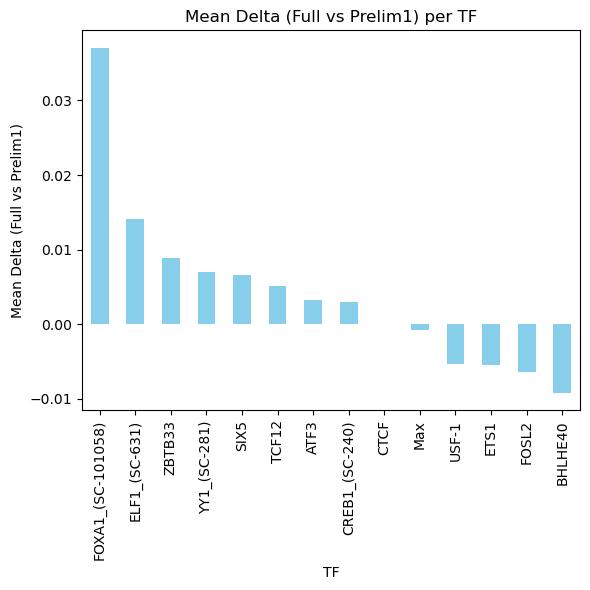

In [10]:
# Group by TF and calculate the mean delta_full_vs_prelim1
tf_delta = pivoted_cleaned.groupby('TF')['delta_full_vs_prelim1'].mean().dropna().sort_values(ascending=False)

# Plot the delta per TF
plt.figure(figsize=(6, 6))
tf_delta.plot(kind='bar', color='skyblue')
plt.title('Mean Delta (Full vs Prelim1) per TF')
plt.xlabel('TF')
plt.ylabel('Mean Delta (Full vs Prelim1)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

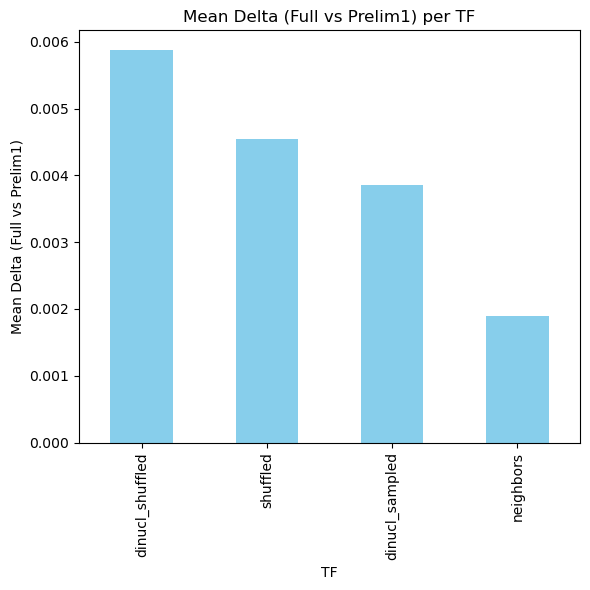

In [12]:
# Group by TF and calculate the mean delta_full_vs_prelim1
tf_delta = pivoted_cleaned.groupby('neg_mode')['delta_full_vs_prelim1'].mean().dropna().sort_values(ascending=False)

# Plot the delta per TF
plt.figure(figsize=(6, 6))
tf_delta.plot(kind='bar', color='skyblue')
plt.title('Mean Delta (Full vs Prelim1) per TF')
plt.xlabel('TF')
plt.ylabel('Mean Delta (Full vs Prelim1)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# Calculate delta between 'full_run_1' and 'prelim_run_2'
pivoted["delta_full_vs_prelim2"] = pivoted["full_run_1"] - pivoted["prelim_run_2"]

# Drop rows with NaN in the 'delta_full_vs_prelim2' column
pivoted_cleaned_prelim2 = pivoted.dropna(subset=["delta_full_vs_prelim2"])

# Show the matched runs and their AUROC deltas for prelim_run_2
display(pivoted_cleaned_prelim2[["celltype", "neg_mode", "TF", "cross_val_set", "full_run_1", "prelim_run_2", "delta_full_vs_prelim2"]])

group_name,celltype,neg_mode,TF,cross_val_set,full_run_1,prelim_run_2,delta_full_vs_prelim2
2062,K562,dinucl_sampled,ATF1_(06-325),0.0,0.929742,0.901103,0.028639
2063,K562,dinucl_sampled,ATF1_(06-325),1.0,0.891138,0.879409,0.011729
2064,K562,dinucl_sampled,ATF1_(06-325),2.0,0.789435,0.922599,-0.133163
2065,K562,dinucl_sampled,ATF1_(06-325),3.0,0.906342,0.922233,-0.015891
2066,K562,dinucl_sampled,ATF1_(06-325),4.0,0.925681,0.930809,-0.005128
...,...,...,...,...,...,...,...
2921,K562,shuffled,Znf143_(16618-1-AP),1.0,0.995660,0.993582,0.002078
2922,K562,shuffled,Znf143_(16618-1-AP),2.0,1.000000,0.959986,0.040014
2923,K562,shuffled,Znf143_(16618-1-AP),3.0,0.995569,0.993725,0.001844
2924,K562,shuffled,Znf143_(16618-1-AP),4.0,0.948912,0.981436,-0.032524


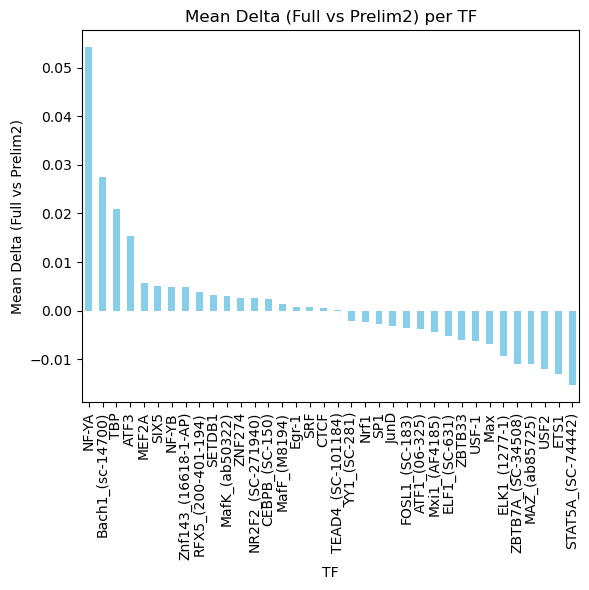

In [11]:
# Group by TF and calculate the mean delta_full_vs_prelim1
tf_delta = pivoted_cleaned_prelim2.groupby('TF')['delta_full_vs_prelim2'].mean().dropna().sort_values(ascending=False)

# Plot the delta per TF
plt.figure(figsize=(6, 6))
tf_delta.plot(kind='bar', color='skyblue')
plt.title('Mean Delta (Full vs Prelim2) per TF')
plt.xlabel('TF')
plt.ylabel('Mean Delta (Full vs Prelim2)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

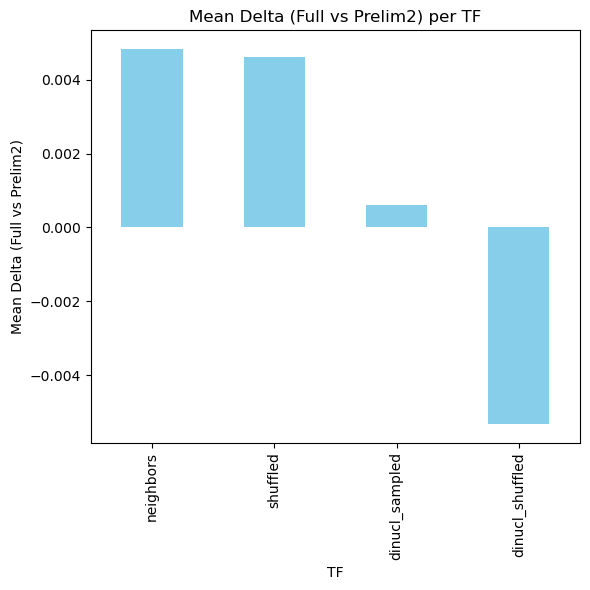

In [13]:
# Group by TF and calculate the mean delta_full_vs_prelim1
tf_delta = pivoted_cleaned_prelim2.groupby('neg_mode')['delta_full_vs_prelim2'].mean().dropna().sort_values(ascending=False)

# Plot the delta per TF
plt.figure(figsize=(6, 6))
tf_delta.plot(kind='bar', color='skyblue')
plt.title('Mean Delta (Full vs Prelim2) per TF')
plt.xlabel('TF')
plt.ylabel('Mean Delta (Full vs Prelim2)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()